In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
# matplotlib.rcParams['font.sans-serif'] = "Latin Modern Roman"
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['mathtext.fontset'] = "cm"
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
import xarray as xr
from xgcm import Grid
import numpy as np
import cmocean
import datetime
import pandas as pd
from dask.diagnostics import ProgressBar
from scipy.ndimage import gaussian_filter
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [3]:
def interp_u2_to_center(u):
    """Interpolate variable (like u or u^2) to xh and yh when it is defined at xq and yh points"""
    layers,ly,lx_p_1 = u.shape
    lx = lx_p_1 - 1
    u_center = np.zeros((layers,ly,lx))
    u_center[:,:,:] = (u[:,:,:-1] + u[:,:,1:])/2
    u_center[:,:,0] = (u[:,:,0] + u[:,:,-1])/2 # periodic
    u_center[:,:,-1] = (u[:,:,0] + u[:,:,-1])/2 # periodic
    
    return u_center
    
def interp_v2_to_center(v):
    """Interpolate variable (like v or v^2) to xh and yh when it is defined at xh and yq points"""
    layers,ly_p_1,lx = v.shape
    ly = ly_p_1 - 1
    v_center = np.zeros((layers,ly,lx))
    v_center[:,:,:] = (v[:,:-1,:] + v[:,1:,:])/2
    
    return v_center

def coarsen_u(u_fine):
    layers,ly,lx_p_1 = u_fine.shape 
    lx = lx_p_1 - 1
    uc_coarse = np.zeros((layers,ly//coarsen,lx//coarsen+1))
    
    # Coarsening uc to uc_coarse
    for j in range(coarsen):
        uc_coarse[:,:,:] = uc_coarse[:,:,:] + u_fine[:,j::coarsen,::coarsen]
    
    return uc_coarse/coarsen

def coarsen_v(v_fine):
    layers,ly_p_1,lx = v_fine.shape 
    ly = ly_p_1 - 1
    vc_coarse = np.zeros((layers,ly//coarsen+1,lx//coarsen))
    
    # Coarsening uc to uc_coarse
    for i in range(coarsen):
        vc_coarse[:,:,:] = vc_coarse[:,:,:] + v_fine[:,::coarsen,i::coarsen]
    
    return vc_coarse/coarsen

def coarsen_h(h_fine):
    layers,ly,lx = h_fine.shape 
    hc_coarse = np.zeros((layers,ly//coarsen,lx//coarsen))
    
    # Coarsening h to hc_coarse
    for j in range(coarsen):
        for i in range(coarsen):
            hc_coarse[:,:,:] = hc_coarse[:,:,:] + h_fine[:,j::coarsen,i::coarsen]
    
    return hc_coarse/(coarsen**2)

In [4]:
run = [20,26,28]

sn1 = xr.open_dataset('run20/snapshots_00030005.nc', decode_times=False)
sn2 = xr.open_dataset('run26/snapshots_00030005.nc', decode_times=False)
sn3 = xr.open_dataset('run28/snapshots_00030005.nc', decode_times=False)

st1 = xr.open_dataset('run20/static.nc', decode_times=False)
st2 = xr.open_dataset('run26/static.nc', decode_times=False)
st3 = xr.open_dataset('run28/static.nc', decode_times=False)

av1 = xr.open_dataset('run20/averages_00030002.nc', decode_times=False)
av2 = xr.open_dataset('run26/averages_00030002.nc', decode_times=False)
av3 = xr.open_dataset('run28/averages_00030002.nc', decode_times=False)

coarsen = 2
layers = len(av1.zl)
time = av1.time
xh1 = st1.xh.values
yh1 = st1.yh.values
xh2 = st2.xh.values
yh2 = st2.yh.values
xh3 = st3.xh.values
yh3 = st3.yh.values

In [5]:
av1

<xarray.Dataset>
Dimensions:     (nv: 2, time: 100, xh: 240, xq: 241, yh: 560, yq: 561, zi: 16, zl: 15)
Coordinates:
  * xq          (xq) float64 0.0 0.25 0.5 0.75 1.0 ... 59.25 59.5 59.75 60.0
  * yh          (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * zl          (zl) float64 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * time        (time) float64 3e+04 3.001e+04 3.001e+04 ... 3.049e+04 3.05e+04
  * nv          (nv) float64 1.0 2.0
  * xh          (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * yq          (yq) float64 -70.0 -69.75 -69.5 -69.25 ... 69.25 69.5 69.75 70.0
  * zi          (zi) float64 1.022e+03 1.023e+03 ... 1.028e+03 1.028e+03
Data variables:
    u           (time, zl, yh, xq) float32 ...
    v           (time, zl, yq, xh) float32 ...
    h           (time, zl, yh, xh) float32 ...
    e2          (time, zi, yh, xh) float32 ...
    uh          (time, zl, yh, xq) float32 ...
    vh          (time, zl, yq, xh) float32 ...
    PV          (time, zl, yq, xq) float32 ...
    dudt        (time, zl, yh, xq) float32 ...
    dvdt        (time, zl, yq, xh) float32 ...
    CAu         (time, zl, yh, xq) float32 ...
    CAv         (time, zl, yq, xh) float32 ...
    rvxu        (time, zl, yq, xh) float32 ...
    rvxv        (time, zl, yh, xq) float32 ...
    gKEu        (time, zl, yh, xq) float32 ...
    gKEv        (time, zl, yq, xh) float32 ...
    PFu         (time, zl, yh, xq) float32 ...
    PFv         (time, zl, yq, xh) float32 ...
    diffu       (time, zl, yh, xq) float32 ...
    diffv       (time, zl, yq, xh) float32 ...
    du_dt_visc  (time, zl, yh, xq) float32 ...
    dv_dt_visc  (time, zl, yq, xh) float32 ...
    u_BT_accel  (time, zl, yh, xq) float32 ...
    v_BT_accel  (time, zl, yq, xh) float32 ...
    KE          (time, zl, yh, xh) float32 ...
    dKE_dt      (time, zl, yh, xh) float32 ...
    PE_to_KE    (time, zl, yh, xh) float32 ...
    KE_BT       (time, zl, yh, xh) float32 ...
    KE_CorAdv   (time, zl, yh, xh) float32 ...
    KE_adv      (time, zl, yh, xh) float32 ...
    KE_visc     (time, zl, yh, xh) float32 ...
    KE_horvisc  (time, zl, yh, xh) float32 ...
    Rd_dx       (time, yh, xh) float32 ...
    Rd1         (time, yh, xh) float32 ...
    average_T1  (time) float64 ...
    average_T2  (time) float64 ...
    average_DT  (time) float64 ...
    time_bnds   (time, nv) float64 ...
Attributes:
    filename:          averages_00030002.nc
    title:             NeverWorld2
    associated_files:  area_t: static.nc
    grid_type:         regular
    grid_tile:         N/A

In [6]:
plots = len(run)

Rd1 = av1.Rd1
Rd2 = av2.Rd1
Rd3 = av3.Rd1

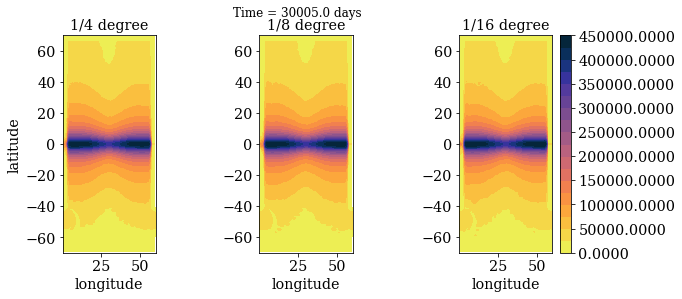

In [7]:
time = sn1.time
for i in range(1):  
    vmin = 0.1 #min(np.nanmin((Rd1[i])),np.nanmin((Rd2[i])))
    vmax = max(np.nanmax((Rd1[i])),np.nanmax((Rd2[i])))
    plt.figure(figsize=(10,4))
    plt.suptitle('Time = %.1f days' %time[i])
    plt.subplot(1,plots,1)
    plt.contourf(xh1,yh1,(Rd1[i]), cmap=cmocean.cm.thermal_r,levels=20)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.clim(vmin, vmax)
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title('1/4 degree')
    plt.subplot(1,plots,2)
    plt.contourf(xh2,yh2,(Rd2[i]), cmap=cmocean.cm.thermal_r,levels=20)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.clim(vmin, vmax)
    plt.xlabel('longitude')
    plt.title('1/8 degree')
    plt.subplot(1,plots,3)
    plt.contourf(xh3,yh3,(Rd3[i]), cmap=cmocean.cm.thermal_r,levels=20)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.clim(vmin, vmax)
    plt.xlabel('longitude')
    plt.title('1/16 degree')
    plt.colorbar(format='%.4f')
#     save_name = 'KE3/fig_'+'{0:06}'.format(int(time[i]))+ '.png'
    plt.savefig('Rd1.png', dpi=200,bbox_inches='tight',pad_inches=0)
#     plt.close()

In [8]:
plots = len(run)

Rd_dx1 = av1.Rd_dx
Rd_dx2 = av2.Rd_dx
Rd_dx3 = av3.Rd_dx

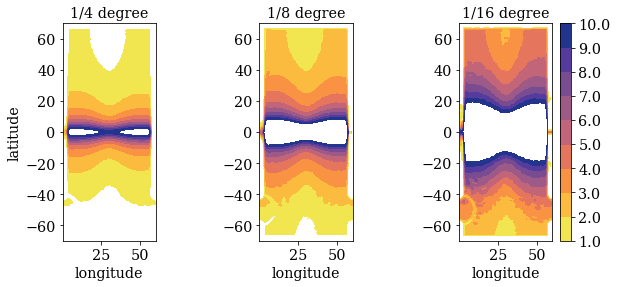

In [9]:
for i in range(1):  
    vmin = 1 # max(np.nanmin(Rd_dx1[i]),np.nanmin(Rd_dx3[i]))
    vmax = 11#max(np.nanmax(Rd_dx1[i]),np.nanmax(Rd_dx3[i]))/4
    ci = np.arange(vmin,vmax,1)
    plt.figure(figsize=(10,4))
#     plt.suptitle('Time = %.1f days' %time[i])
    plt.subplot(1,plots,1)
    plt.contourf(xh1,yh1,Rd_dx1[i], cmap=cmocean.cm.thermal_r,levels = ci)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.clim(vmin, vmax)
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title('1/4 degree')
    plt.subplot(1,plots,2)
    plt.contourf(xh2,yh2,Rd_dx2[i], cmap=cmocean.cm.thermal_r,levels = ci)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.clim(vmin, vmax)
    plt.xlabel('longitude')
    plt.title('1/8 degree')
    plt.subplot(1,plots,3)
    plt.contourf(xh3,yh3,Rd_dx3[i], cmap=cmocean.cm.thermal_r,levels = ci)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.clim(vmin, vmax)
    plt.xlabel('longitude')
    plt.title('1/16 degree')
    plt.colorbar(format='%.1f')
#     save_name = 'KE3/fig_'+'{0:06}'.format(int(time[i]))+ '.png'
    plt.savefig('Rd_dx.png', dpi=200,bbox_inches='tight',pad_inches=0)
#     plt.close()

In [10]:
grid1 = Grid(av1, coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'},
                        'Z': {'center': 'z_l', 'outer': 'z_i'} }, periodic=['X'])
grid2 = Grid(av2, coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'},
                        'Z': {'center': 'z_l', 'outer': 'z_i'} }, periodic=['X'])

In [11]:
u1 = sn1.u[0]
v1 = sn1.v[0]
u2 = sn2.u[0]
v2 = sn2.v[0]
h1 = sn1.h[0]
h2 = sn2.h[0]

KE1 = 0.5*(grid1.interp(u1**2, 'X') + grid1.interp(v1**2, 'Y'))
KE2 = 0.5*(grid2.interp(u2**2, 'X') + grid2.interp(v2**2, 'Y'))

uf2 = np.zeros(u2.shape)
vf2 = np.zeros(v2.shape)


for l in range(layers):
    uf2[l,:,:] = gaussian_filter(u2[l,:,:], sigma=8)
    vf2[l,:,:] = gaussian_filter(v2[l,:,:], sigma=8)
    
KEf2 = 0.5* (interp_u2_to_center(uf2**2) + interp_v2_to_center(vf2**2))

KE1_depth_averaged = KE1*h1/st1.depth_ocean
KE1_depth_averaged = KE1_depth_averaged.mean(axis=0)
KE2_depth_averaged = KE2*h2/st2.depth_ocean
KE2_depth_averaged = KE2_depth_averaged.mean(axis=0)
KEf2_depth_averaged = KEf2*h2/st2.depth_ocean
KEf2_depth_averaged = KEf2_depth_averaged.mean(axis=0)

In [12]:
ufc2 = np.zeros(u1.shape)
vfc2 = np.zeros(v1.shape)

In [13]:
ufc2 = coarsen_u(uf2)
vfc2 = coarsen_v(vf2)

In [14]:
KEfc2 = 0.5* (interp_u2_to_center(ufc2**2) + interp_v2_to_center(vfc2**2))

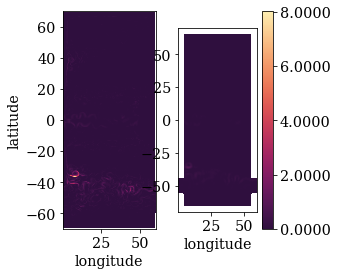

In [15]:
vmin = min(np.nanmin(KE2),np.nanmin(KEf2))
vmax = max(np.nanmax(KE2),np.nanmax(KEf2))
plt.figure(figsize=(6,4))
plt.subplot(1,plots,1)
plt.pcolormesh(xh2,yh2,av2.KE[0,0], cmap=cmocean.cm.matter_r)
plt.gca().set_aspect('equal', adjustable='box')
plt.clim(vmin, vmax)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.subplot(1,plots,2)
plt.pcolormesh(xh2,yh2,KEf2[0], cmap=cmocean.cm.matter_r)
plt.gca().set_aspect('equal', adjustable='box')
plt.clim(vmin, vmax)
plt.xlabel('longitude')
plt.colorbar(format='%.4f')
plt.savefig('KE_filtered.png', dpi=200,bbox_inches='tight',pad_inches=0)


In [16]:
KEfc2_depth_averaged = KEfc2*coarsen_h(h2)
KEfc2_depth_averaged = KEfc2_depth_averaged.mean(axis=0)/st1.depth_ocean

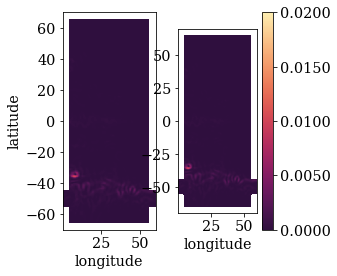

In [17]:
vmin = min(np.nanmin(KEfc2_depth_averaged),np.nanmin(KEf2_depth_averaged))
vmax = max(np.nanmax(KEfc2_depth_averaged),np.nanmax(KEf2_depth_averaged))
plt.figure(figsize=(6,4))
plt.subplot(1,plots,1)
plt.pcolormesh(xh1,yh1,KEfc2_depth_averaged, cmap=cmocean.cm.matter_r)
plt.gca().set_aspect('equal', adjustable='box')
plt.clim(0, 0.02)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.subplot(1,plots,2)
plt.pcolormesh(xh2,yh2,KEf2_depth_averaged, cmap=cmocean.cm.matter_r)
plt.gca().set_aspect('equal', adjustable='box')
plt.clim(0, 0.02)
plt.xlabel('longitude')
plt.colorbar(format='%.4f')
save_name = 'KE_eighth_degree.png'
plt.savefig(save_name, dpi=200,bbox_inches='tight',pad_inches=0)
# plt.close()

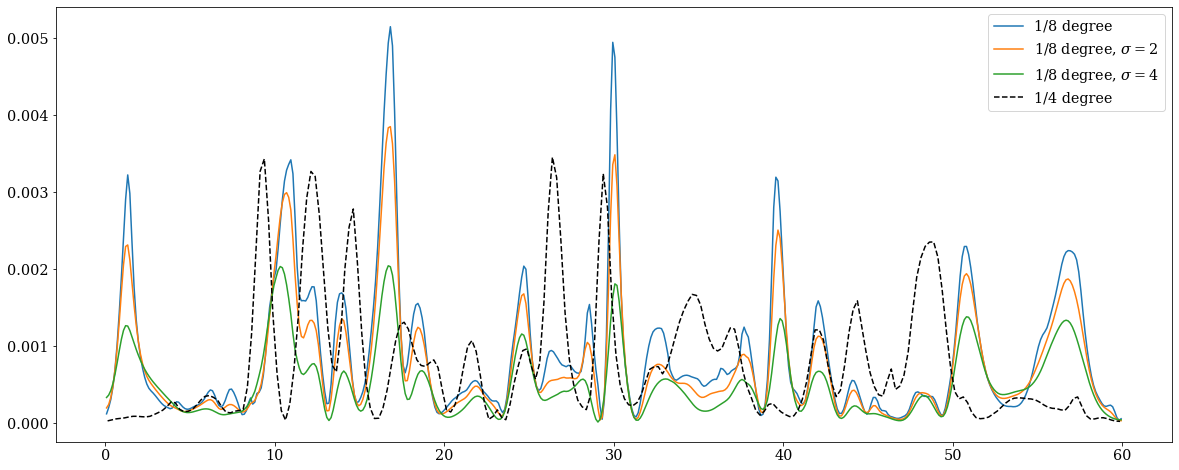

In [18]:
S = [2,4]

plt.figure(figsize=(20,8))
plt.plot(xh2,KE2_depth_averaged[160,:])
for s in range(len(S)):
    for l in range(layers):
        uf2[l,:,:] = gaussian_filter(u2[l,:,:], sigma=S[s])
        vf2[l,:,:] = gaussian_filter(v2[l,:,:], sigma=S[s])

    KEf2 = 0.5* (interp_u2_to_center(uf2**2) + interp_v2_to_center(vf2**2))
    KEf2_depth_averaged = KEf2*h2/st2.depth_ocean
    KEf2_depth_averaged = KEf2_depth_averaged.mean(axis=0)
    
    plt.plot(xh2,KEf2_depth_averaged[160,:])
    
plt.plot(xh1,KE1_depth_averaged[80,:],'k--')

plt.gca().legend((r'1/8 degree', '1/8 degree, $\sigma=2$', '1/8 degree, $\sigma=4$','1/4 degree')) 
plt.savefig('ACC_KE.png', dpi=200,bbox_inches='tight',pad_inches=0)

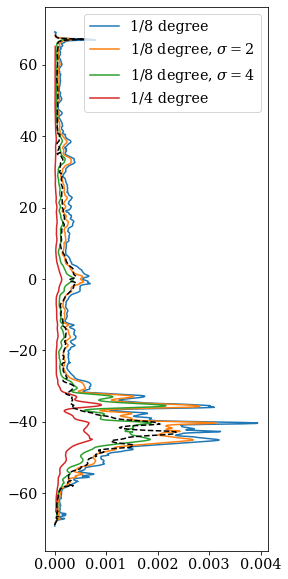

In [19]:
S = [2,4]

time = sn2.time

KE_z_1 = np.zeros(len(yh1))
KE_z_2 = np.zeros(len(yh2))
KE_zf_2 = np.zeros(len(yh2))
KE_zf_4 = np.zeros(len(yh2))

for i in range(1):
    u2 = sn2.u[i]
    v2 = sn2.v[i]
    h1 = sn1.h[i]
    h2 = sn2.h[i]

    plt.figure(figsize=(4,10))
    plt.plot(KE2_depth_averaged.mean(axis=1),yh2)
    for s in range(len(S)):
        for l in range(layers):
            uf2[l,:,:] = gaussian_filter(u2[l,:,:], sigma=S[s])
            vf2[l,:,:] = gaussian_filter(v2[l,:,:], sigma=S[s])

        KEf2 = 0.5* (interp_u2_to_center(uf2**2) + interp_v2_to_center(vf2**2))
        KEf2_depth_averaged = KEf2*h2/st2.depth_ocean
        KEf2_depth_averaged = KEf2_depth_averaged.mean(axis=0)

        plt.plot(KEf2_depth_averaged.mean(axis=1),yh2)
        if s==0:
            ufc2 = coarsen_u(uf2)
            vfc2 = coarsen_v(vf2)
            KEfc2_depth_averaged = KEfc2*coarsen_h(h2)
            KEfc2_depth_averaged = KEfc2_depth_averaged.mean(axis=0)/st1.depth_ocean
    
    plt.plot(KEfc2_depth_averaged.mean(axis=1),yh1)
    plt.plot(KE1_depth_averaged.mean(axis=1),yh1,'k--')

plt.gca().legend((r'1/8 degree', '1/8 degree, $\sigma=2$', '1/8 degree, $\sigma=4$','1/4 degree')) 
plt.savefig('zonal_KE.png', dpi=200,bbox_inches='tight',pad_inches=0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


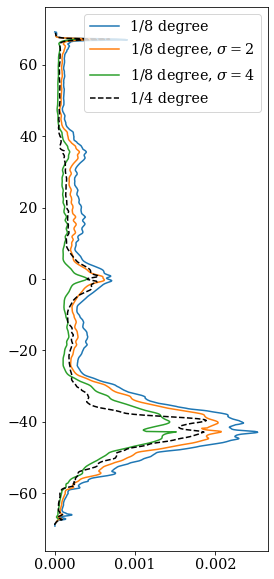

In [20]:
S = [2,4]

time = sn2.time

weights_h1 = np.cos(np.deg2rad(st1.xh))
weights_h2 = np.cos(np.deg2rad(st2.xh))

KE_z_1 = np.zeros(len(yh1))
KE_z_2 = np.zeros(len(yh2))
KE_zf_2 = np.zeros(len(yh2))
KE_zf_4 = np.zeros(len(yh2))

for i in range(len(time)):
    print(i)
    u1 = sn1.u[i]
    v1 = sn1.v[i]
    u2 = sn2.u[i]
    v2 = sn2.v[i]
    h1 = sn1.h[i]
    h2 = sn2.h[i]
    
    KE1 = 0.5*(grid1.interp(u1**2, 'X') + grid1.interp(v1**2, 'Y'))
    KE2 = 0.5*(grid2.interp(u2**2, 'X') + grid2.interp(v2**2, 'Y'))
    KE1_depth_averaged = KE1*h1/st1.depth_ocean
    KE1_depth_averaged = KE1_depth_averaged.mean(axis=0)
    KE2_depth_averaged = KE2*h2/st2.depth_ocean
    KE2_depth_averaged = KE2_depth_averaged.mean(axis=0)

    KE_z_2 = KE_z_2 + KE2_depth_averaged.weighted(weights_h2).mean(dim=['xh'])
    KE_z_1 = KE_z_1 + KE1_depth_averaged.weighted(weights_h1).mean(dim=['xh'])
    
    for s in range(len(S)):
        for l in range(layers):
            uf2[l,:,:] = gaussian_filter(u2[l,:,:], sigma=S[s])
            vf2[l,:,:] = gaussian_filter(v2[l,:,:], sigma=S[s])

        KEf2 = 0.5* (interp_u2_to_center(uf2**2) + interp_v2_to_center(vf2**2))
        KEf2_depth_averaged = KEf2*h2/st2.depth_ocean
        KEf2_depth_averaged = KEf2_depth_averaged.mean(axis=0)
        if s==0:
            KE_zf_2 = KE_zf_2 + KEf2_depth_averaged.weighted(weights_h2).mean(dim=['xh'])
        else:
            KE_zf_4 = KE_zf_4 + KEf2_depth_averaged.weighted(weights_h2).mean(dim=['xh'])

    
plt.figure(figsize=(4,10))
plt.plot(KE_z_2/len(time),yh2)
plt.plot(KE_zf_2/len(time),yh2)
plt.plot(KE_zf_4/len(time),yh2)
plt.plot(KE_z_1/len(time),yh1,'k--')
plt.gca().legend((r'1/8 degree', '1/8 degree, $\sigma=2$', '1/8 degree, $\sigma=4$','1/4 degree')) 
plt.savefig('zonal_KE.png', dpi=200,bbox_inches='tight',pad_inches=0)

In [21]:
acc1 = np.zeros((500))
acc2 = np.zeros((500))

acc1_temp = av1.uh.sel(yh=slice(-60,-40))
acc1_temp = acc1_temp[:,:,:,0]
acc2_temp = av2.uh.sel(yh=slice(-60,-40))
acc2_temp = acc2_temp[:,:,:,0]
acc1 = np.nansum(np.nansum(acc1_temp, axis=2),axis=1)
acc2 = np.nansum(np.nansum(acc2_temp, axis=2),axis=1)

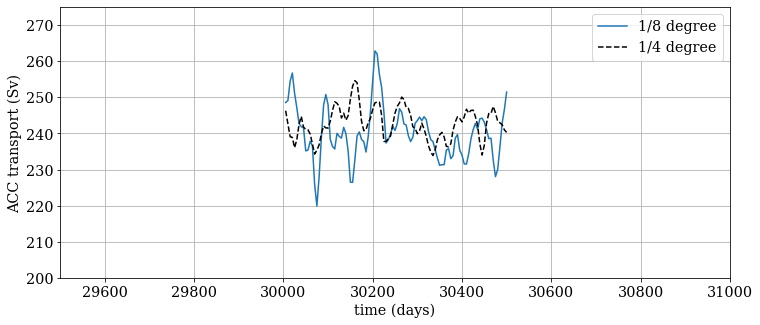

In [22]:
plt.figure(figsize=(12,5))

plt.plot(time,acc2/1e6)
plt.plot(time,acc1/1e6,'k--')
plt.ylabel('ACC transport (Sv)')
plt.xlabel('time (days)')
plt.gca().legend(('1/8 degree','1/4 degree'))
plt.grid()
plt.axis((29500,31000,200,275))
plt.savefig('ACC_transport.png', dpi=200,bbox_inches='tight',pad_inches=0)

In [23]:
budget_terms_ke2 = ['dKE_dt', 'KE_CorAdv', 'PE_to_KE', 'KE_BT', 'KE_visc', 'KE_horvisc']
ds_budget_ke2 = xr.concat([av2[term] for term in budget_terms_ke2],
                        xr.DataArray(budget_terms_ke2, dims=['term'], name='term'))
budget_terms_ke1 = ['dKE_dt', 'KE_CorAdv', 'PE_to_KE', 'KE_BT', 'KE_visc', 'KE_horvisc']
ds_budget_ke1 = xr.concat([av1[term] for term in budget_terms_ke1],
                        xr.DataArray(budget_terms_ke1, dims=['term'], name='term'))
spatial_mean_ke_budget2 = ds_budget_ke2.weighted(weights_h2).mean(dim=['yh', 'xh'])
spatial_mean_ke_budget1 = ds_budget_ke1.weighted(weights_h1).mean(dim=['yh', 'xh'])

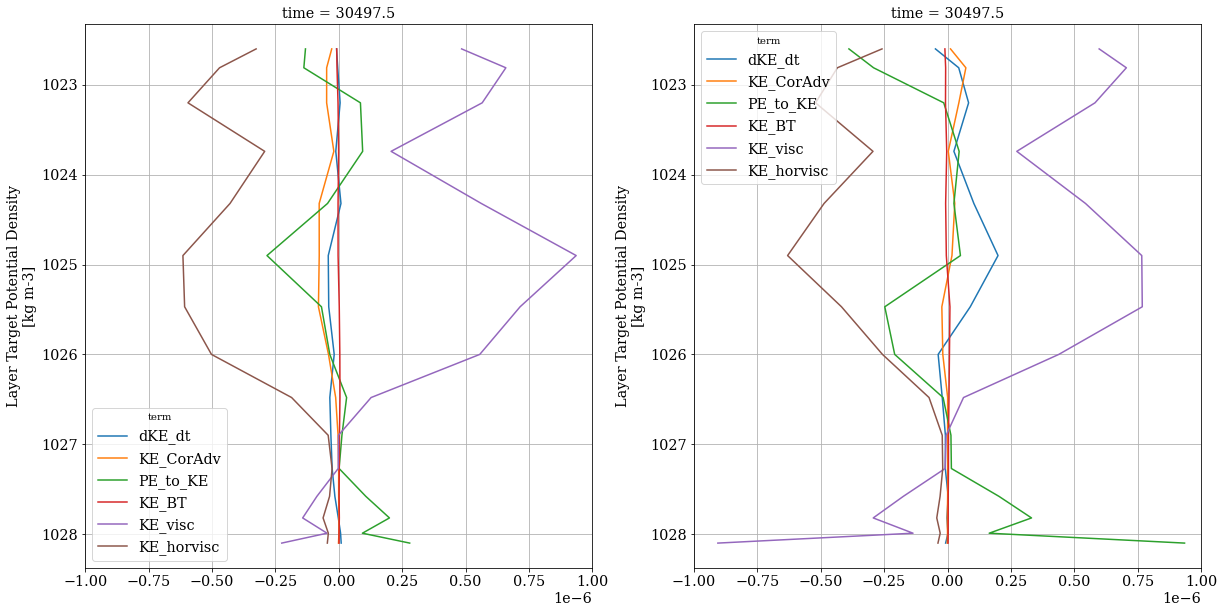

In [24]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
spatial_mean_ke_budget_plot1 = spatial_mean_ke_budget1.isel(time=-1).load()
spatial_mean_ke_budget_plot1.plot.line(hue='term', y='zl', yincrease=False)
plt.xlim((-1e-6,1e-6))

plt.grid()
plt.subplot(1,2,2)
spatial_mean_ke_budget_plot2 = spatial_mean_ke_budget2.isel(time=-1).load()
spatial_mean_ke_budget_plot2.plot.line(hue='term', y='zl', yincrease=False)
plt.grid()
plt.xlim((-1e-6,1e-6))

plt.savefig('depth_KE.png', dpi=200,bbox_inches='tight',pad_inches=0)

In [25]:
ssh1 = sn1.h.sum(axis=1) - st1.depth_ocean
ssh2 = sn2.h.sum(axis=1) - st2.depth_ocean

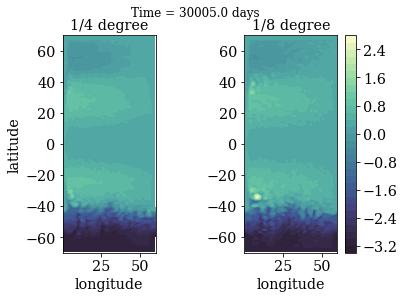

In [27]:
time = sn1.time
vmin = min(np.nanmin(ssh1),np.nanmin(ssh2))
vmax = max(np.nanmax(ssh1),np.nanmax(ssh2))
ci = np.arange(round(vmin)-0.4,round(vmax),0.2)
for i in range(1): # range(len(time)) to save multiple images
    plt.figure(figsize=(6,4))
    plt.suptitle('Time = %.1f days' %time[i])
    plt.subplot(1,2,1)
    plt.contourf(xh1,yh1,ssh1[i], cmap=cmocean.cm.deep_r,levels = ci)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title('1/4 degree')
    plt.subplot(1,2,2)
    plt.contourf(xh2,yh2,ssh2[i], cmap=cmocean.cm.deep_r,levels = ci)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('longitude')
    plt.title('1/8 degree')
    plt.colorbar()
#     save_name = 'SSH3/fig_'+'{0:06}'.format(int(time[i]))+ '.png'
#     plt.savefig(save_name, dpi=200,bbox_inches='tight',pad_inches=0)
#     plt.close()